A notebook for the initial development of Guassian non-linear regression model synthesis development

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy.linalg
import numpy as np
import torch

from janelia_core.ml.extra_torch_modules import DenseLNLNet
from janelia_core.ml.extra_torch_modules import QuadSurf
from janelia_core.ml.utils import list_torch_devices

from probabilistic_model_synthesis.gaussian_nonlinear_regression import align_low_d_spaces
from probabilistic_model_synthesis.gaussian_nonlinear_regression import compare_weight_prior_dists
from probabilistic_model_synthesis.gaussian_nonlinear_regression import Fitter
from probabilistic_model_synthesis.gaussian_nonlinear_regression import generate_basic_posteriors
from probabilistic_model_synthesis.gaussian_nonlinear_regression import generate_hypercube_prior_collection
from probabilistic_model_synthesis.gaussian_nonlinear_regression import GNLRMdl
from probabilistic_model_synthesis.gaussian_nonlinear_regression import VICollection
from probabilistic_model_synthesis.visualization import assign_colors_to_pts
from probabilistic_model_synthesis.visualization import plot_three_dim_pts


In [3]:
%matplotlib notebook

## Parameters go here

In [4]:
# Number of individuals we simulate observing data from 
n_individuals = 5

# Range of the number of input variables we observe from each individual - the actual number of variables we 
# observe from an individual will be pulled uniformly from this range (inclusive)
n_input_var_range = [100, 120]

# Range of the number of samples we observe from each individual - the actual number we observe from each individual
# will be unformly from this range (inclusive)
n_smps_range = [10000, 15000]

# Dimensionality of low-d space input variables are projected to
p = 2

# True if we should use GPUs for fitting if they are available
use_gpus = True

# Parameters for generating shared m-module we use for fitting
m_n_layers = 5 #2
m_growth_rate = 5 #2
n_pred_vars = 3

## Determine which devices we use for fitting

In [5]:
if use_gpus:
    devices, _ = list_torch_devices()
else:
    devices = [torch.device('cpu')]

Found 1 GPUs


## Create the true prior distributions that relate parameters in the model to variables (e.g., neuron) properties

In [6]:
m_true = QuadSurf(torch.tensor([.5, .5]), torch.tensor([.2, -.2]))

In [7]:
hc_params = {'n_divisions_per_dim': [10, 10], 
             'dim_ranges': np.asarray([[-.1, 1.1],
                                       [-.1, 1.1]]),
             'n_div_per_hc_side_per_dim': [1, 1]}

s_prior_opts = {'mn_mn': 1.0, 'mn_std': .001, 'std_iv': .001}
b_prior_opts = {'mn_mn': 0.0, 'mn_std': .001, 'std_iv': .001}
psi_prior_opts = {'conc_iv': 10.0, 'rate_iv': 10.0}


true_priors = generate_hypercube_prior_collection(p=2, d_pred=3, w_mn_init=0.0, w_std_init=1.0,
                                                  hc_params=hc_params, s_in_prior_opts=s_prior_opts, 
                                                  b_in_prior_opts=b_prior_opts, s_out_prior_opts=s_prior_opts,
                                                  b_out_prior_opts=b_prior_opts, psi_prior_opts=psi_prior_opts)

for d in range(p):
    true_priors.w_prior.dists[d].mn_f.b_m.data[:] = torch.randn(true_priors.w_prior.dists[d].mn_f.b_m.data.shape)

## Generate properties

In [8]:
ind_n_vars = np.random.randint(n_input_var_range[0], n_input_var_range[1]+1, n_individuals)
ind_n_smps = np.random.randint(n_smps_range[0], n_smps_range[1]+1, n_individuals)
ind_props = [torch.rand(size=[n_vars,2]) for n_vars in ind_n_vars]

## Generate true models

In [9]:
with torch.no_grad():
    ind_true_mdls = [GNLRMdl(m=m_true, 
                     w=true_priors.w_prior.form_standard_sample(true_priors.w_prior.sample(props)),
                     s_in=true_priors.s_in_prior.form_standard_sample(true_priors.s_in_prior.sample(props)).squeeze(),
                     b_in=true_priors.b_in_prior.form_standard_sample(true_priors.b_in_prior.sample(props)).squeeze(),
                     s_out=true_priors.s_out_prior.form_standard_sample(true_priors.s_out_prior.sample(props)).squeeze(),
                     b_out=true_priors.b_out_prior.form_standard_sample(true_priors.b_out_prior.sample(props)).squeeze(),
                     psi=true_priors.psi_prior.form_standard_sample(true_priors.psi_prior.sample(props)).squeeze())
                     for props in ind_props]
                             

## Generate data from true models

In [10]:
with torch.no_grad():
    ind_data = [None]*n_individuals
    for i in range(n_individuals):
        x_i = torch.randn([ind_n_smps[i], ind_n_vars[i]])
        y_i = ind_true_mdls[i].sample(x_i)
        ind_data[i] = (x_i, y_i)

## Setup everything for fitting

In [11]:
s_post_opts = {'mn_mn': 1.0, 'mn_std': .01}
b_post_opts = {'mn_mn': 0.0, 'mn_std': .01}

In [12]:
m_fit = torch.nn.Sequential(DenseLNLNet(nl_class=torch.nn.ReLU, 
                                        d_in=p, 
                                        n_layers=m_n_layers, 
                                        growth_rate=m_growth_rate, 
                                        bias=True), 
                            torch.nn.Linear(in_features=p+m_n_layers*m_growth_rate, 
                                            out_features=n_pred_vars, 
                                            bias=True))

In [13]:
fit_priors = generate_hypercube_prior_collection(p=2, d_pred=3, w_mn_init=0.0, w_std_init=1.0,
                                                 hc_params=hc_params, s_in_prior_opts=s_prior_opts, 
                                                 b_in_prior_opts=b_prior_opts, s_out_prior_opts=s_prior_opts,
                                                 b_out_prior_opts=b_prior_opts, psi_prior_opts=psi_prior_opts,
                                                 learnable_scales_and_biases=False)

fit_posteriors = generate_basic_posteriors(n_input_vars=ind_n_vars, p=p, n_pred_vars=n_pred_vars, 
                                           s_in_opts=s_post_opts, b_in_opts=b_post_opts, 
                                           s_out_opts=s_post_opts, b_out_opts=b_post_opts)

fit_mdls = [GNLRMdl(m=m_fit) for i in range(n_individuals)]

fit_vi_collections = [VICollection(data=[ind_data[s_i][0], ind_data[s_i][1]], 
                                   props=ind_props[s_i],
                                   mdl = fit_mdls[s_i],
                                   posteriors = fit_posteriors[s_i]) for s_i in range(n_individuals)]

## Fit the models

In [14]:
fitter = Fitter(vi_collections=fit_vi_collections, priors=fit_priors, devices=devices)

In [15]:
fitter.distribute(distribute_data=True, devices=devices)
logs = [fitter.fit(1000, milestones=[100], update_int=100, init_lr=.01) for fit_r in range(1)]
fitter.distribute(distribute_data=True, devices=[torch.device('cpu')])


=========== EPOCH 0 COMPLETE ===========
Obj: 3.25e+08
----------------------------------------
NELL: 5.37e+07, 5.31e+07, 6.40e+07, 7.08e+07, 8.31e+07
W KL: 9.43e+02, 9.43e+02, 9.34e+02, 9.10e+02, 9.84e+02
S_in KL: 1.30e+02, 1.28e+02, 1.34e+02, 1.21e+02, 2.88e+02
B_in KL: 1.27e+02, 1.20e+02, 3.26e+02, 3.03e+02, 1.90e+02
S_out KL: 2.37e+02, 1.80e+02, 1.89e+02, 2.77e+02, 1.99e+02
B_out KL: 4.68e+02, 3.00e+02, 2.21e+02, 2.35e+02, 5.96e+02
Psi KL: 1.09e-02, 1.09e-02, 1.09e-02, 1.09e-02, 1.09e-02
----------------------------------------
LR: 0.01
Elapsed time (secs): 0.41732215881347656
----------------------------------------
CPU cur memory used (GB): 2.56e+00
GPU_0 cur memory used (GB): 2.69e-02, max memory used (GB): 2.69e-02

=========== EPOCH 100 COMPLETE ===========
Obj: 3.30e+06
----------------------------------------
NELL: 4.54e+05, 6.36e+05, 5.43e+05, 6.85e+05, 8.80e+05
W KL: 8.31e+02, 8.38e+02, 8.32e+02, 7.89e+02, 8.45e+02
S_in KL: 1.06e+03, 2.78e+03, 1.36e+03, 2.89e+03, 3.91e+03

## Examine logs of fitting performance

<IPython.core.display.Javascript object>


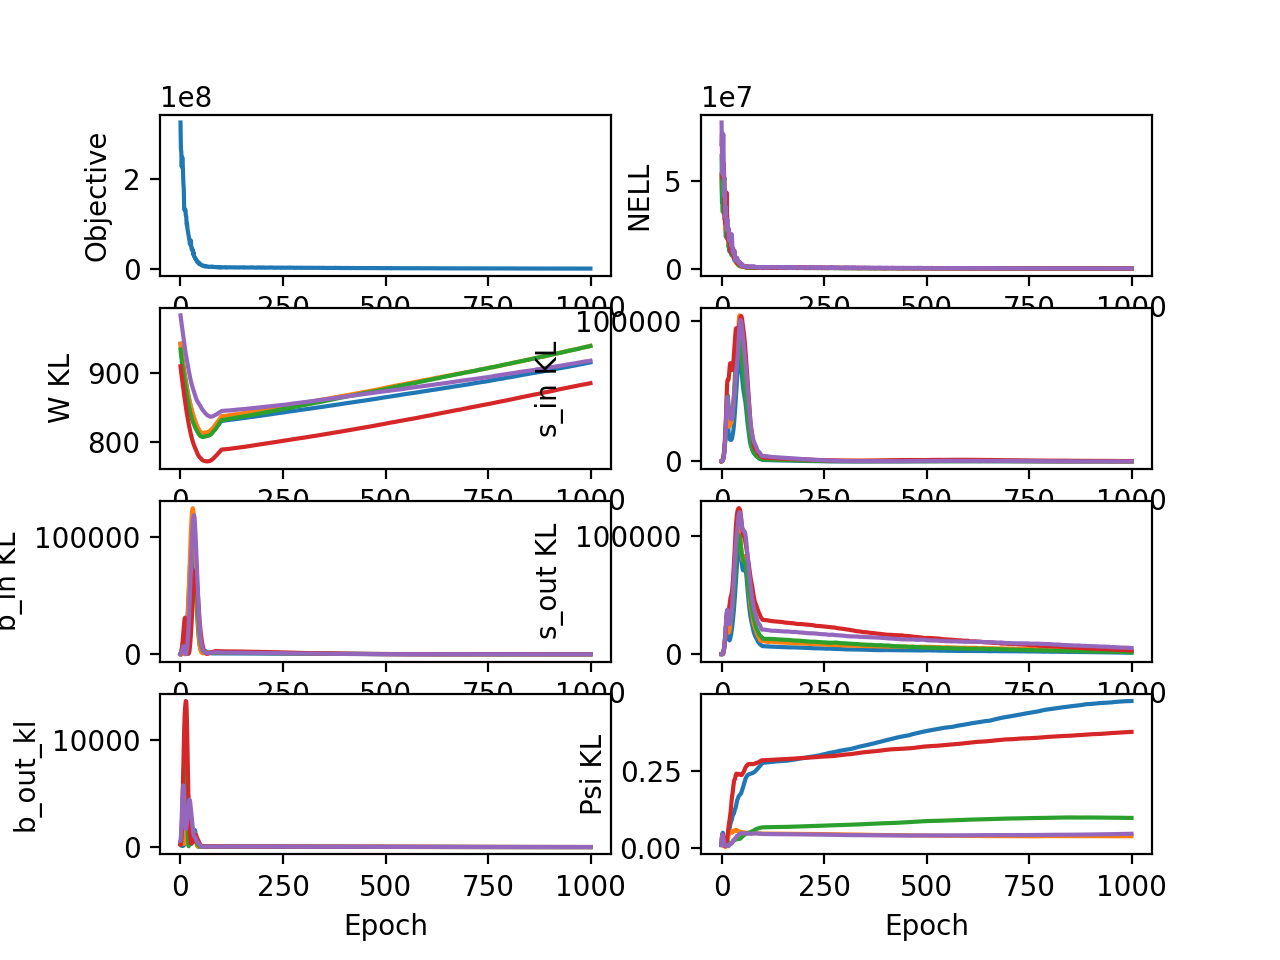

In [16]:
for log in logs:
    fitter.plot_log(log)

## Look at model fits

In [17]:
exam_mdl = 1

<IPython.core.display.Javascript object>


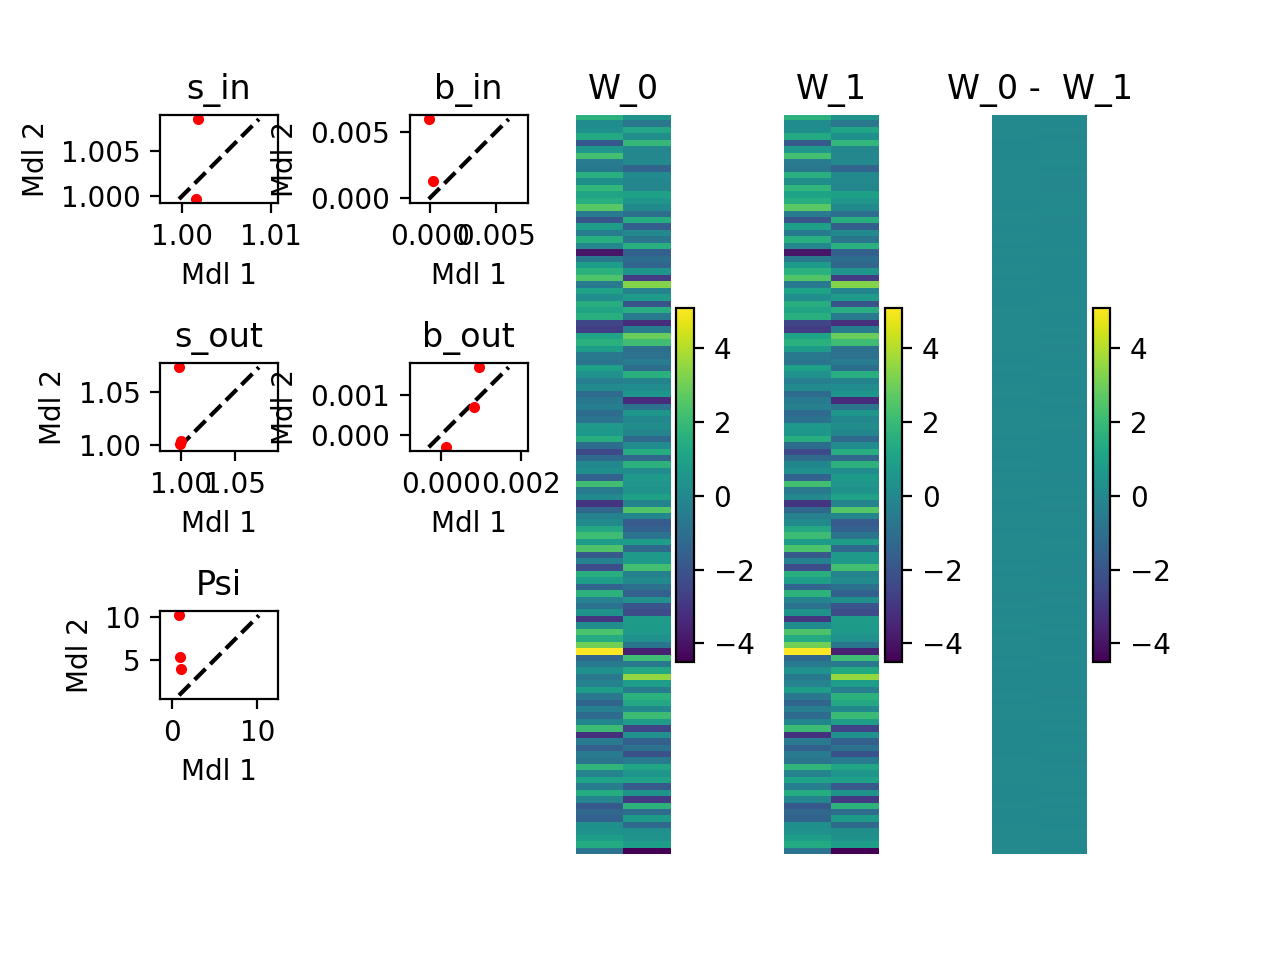

In [19]:
fit_w = fit_posteriors[exam_mdl].w_post(ind_props[0])
fit_s_in = fit_posteriors[exam_mdl].s_in_post(ind_props[0]).squeeze()
fit_b_in = fit_posteriors[exam_mdl].b_in_post(ind_props[0]).squeeze()
fit_s_out = fit_posteriors[exam_mdl].s_out_post(ind_props[0]).squeeze()
fit_b_out = fit_posteriors[exam_mdl].b_out_post(ind_props[0]).squeeze()
fit_psi = fit_posteriors[exam_mdl].psi_post.dists[0].mode(ind_props[0]).squeeze()

fit_mdl = GNLRMdl(m = fit_vi_collections[0].mdl.m, w=fit_w, s_in=fit_s_in, b_in=fit_b_in, s_out=fit_s_out,
                  b_out=fit_b_out, psi=fit_psi)

plt.figure()
GNLRMdl.compare_mdls(ind_true_mdls[exam_mdl], fit_mdl)

## Look at true and estimated projections


In [20]:
z_true = ind_true_mdls[exam_mdl].project(ind_data[exam_mdl][0])
l_true = ind_true_mdls[exam_mdl].m(z_true)
z_true = z_true.detach().cpu().numpy()
l_true = l_true.detach().cpu().numpy()

z_fit = fit_mdls[exam_mdl].project(x=ind_data[exam_mdl][0], w=fit_w, s_in=fit_s_in, b_in=fit_b_in)
l_fit = fit_mdls[exam_mdl].m(z_fit)
z_fit = z_fit.detach().cpu().numpy()
l_fit = l_fit.detach().cpu().numpy()

In [21]:
aligned_vls = align_low_d_spaces(w0=ind_true_mdls[exam_mdl].w.detach().numpy(), 
                         s_in_0=ind_true_mdls[exam_mdl].s_in.detach().numpy(), 
                         b_in_0=ind_true_mdls[exam_mdl].b_in.detach().numpy(), 
                         w1=fit_w.detach().numpy(),
                         s_in_1=fit_s_in.detach().numpy(),
                         b_in_1=fit_b_in.detach().numpy(),
                         z1=z_fit)

z_fit_aligned = aligned_vls[-1]

<IPython.core.display.Javascript object>


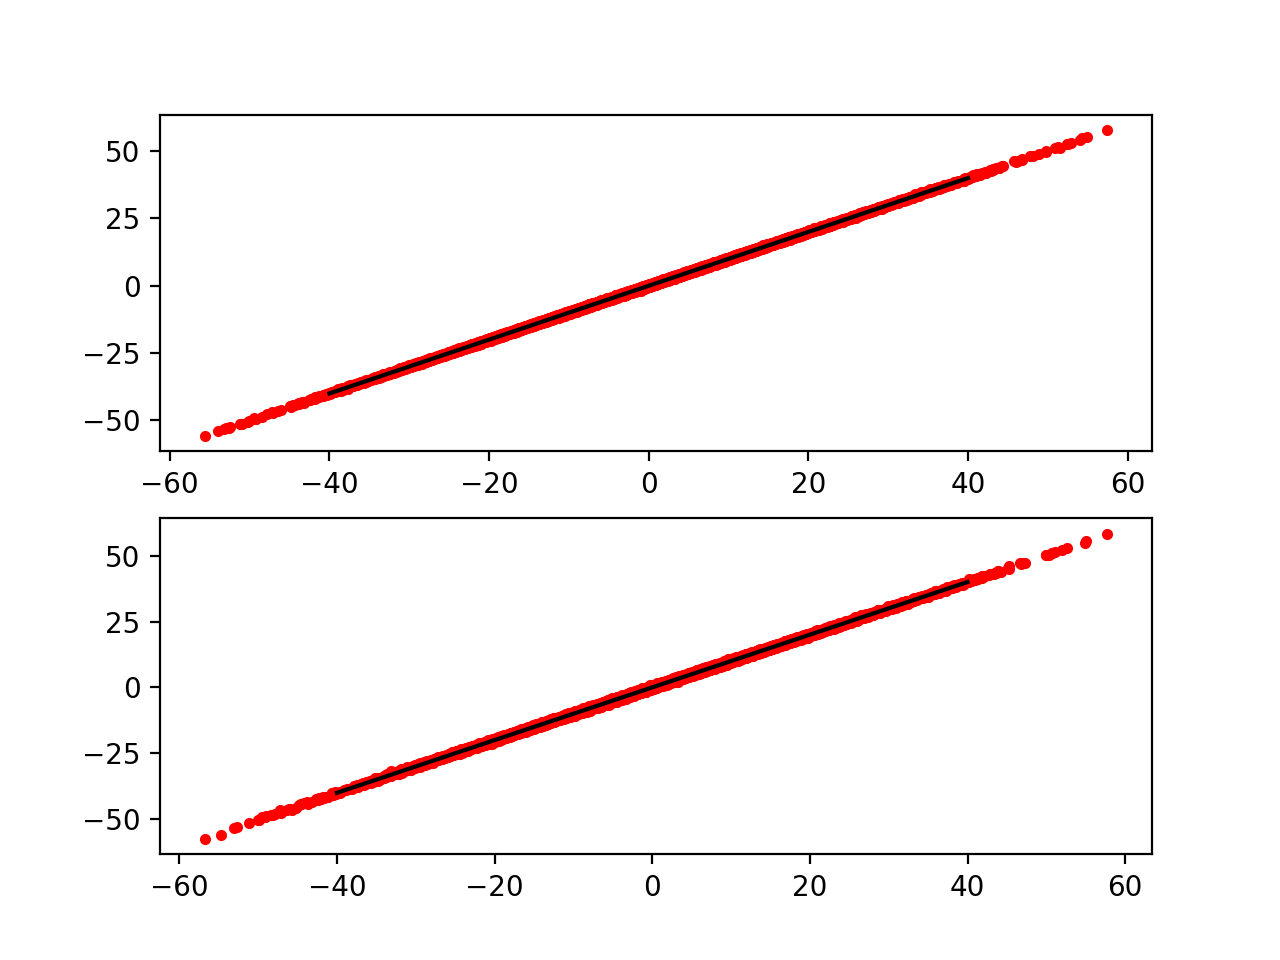

In [22]:
plt.figure()
for i in range(2):
    plt.subplot(2,1,i+1)
    plt.plot(z_true[:, i], z_fit_aligned[:, i], 'r.')
    plt.plot([-40, 40], [-40, 40], 'k-')

In [23]:
clrs = assign_colors_to_pts(z_true, lims=np.asarray([[-30, 30], [-30, 30]]))

<IPython.core.display.Javascript object>


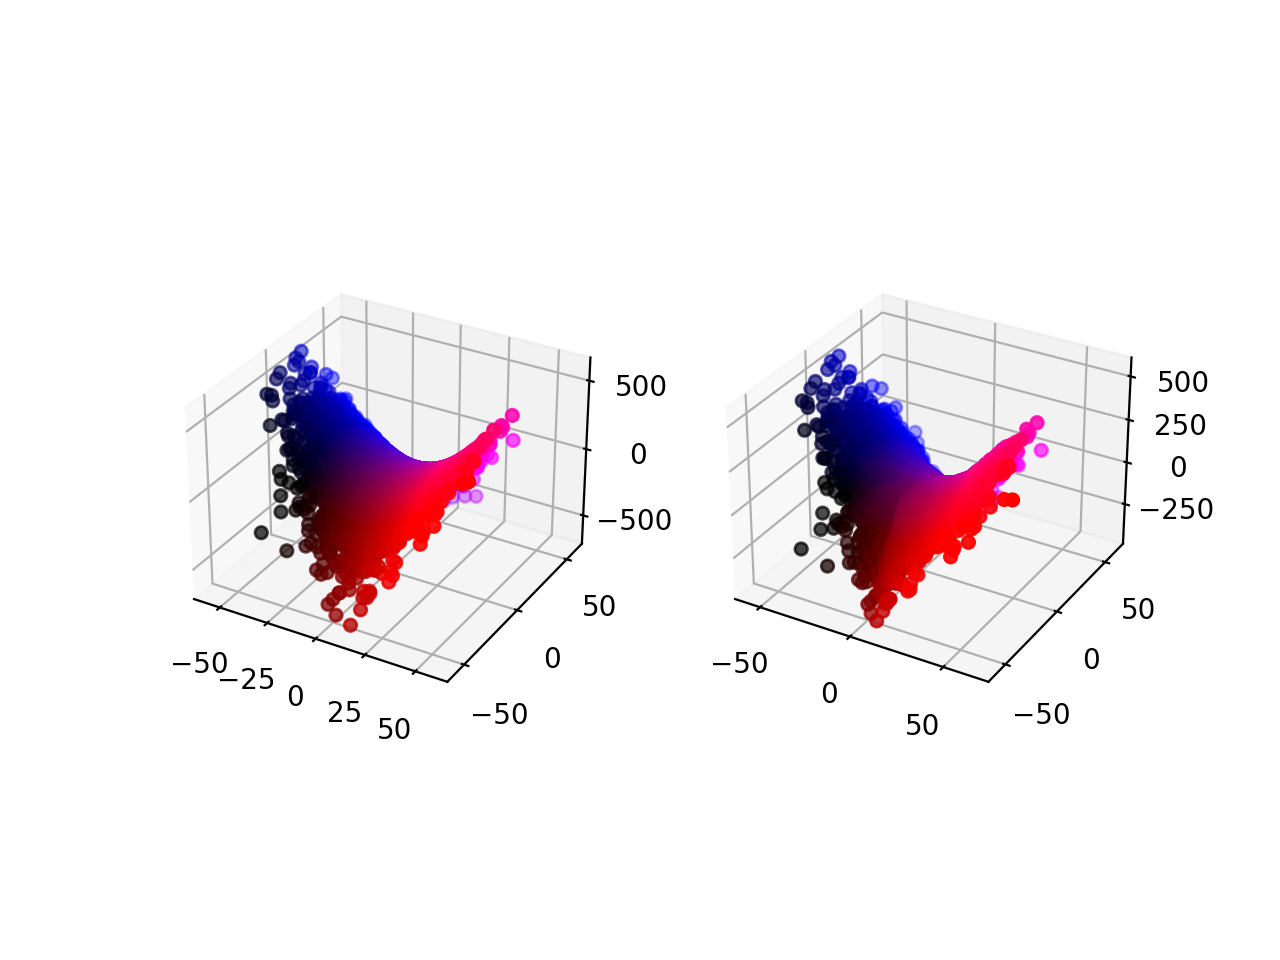

<Axes3DSubplot:>

In [24]:
plt.figure()
a = plt.subplot(1,2,1, projection='3d')
plot_three_dim_pts(l_true, clrs=clrs, a=a)

a = plt.subplot(1,2,2, projection='3d')
plot_three_dim_pts(l_fit, clrs=clrs, a=a)

## Compare true and fit prior distributions on weights

<IPython.core.display.Javascript object>


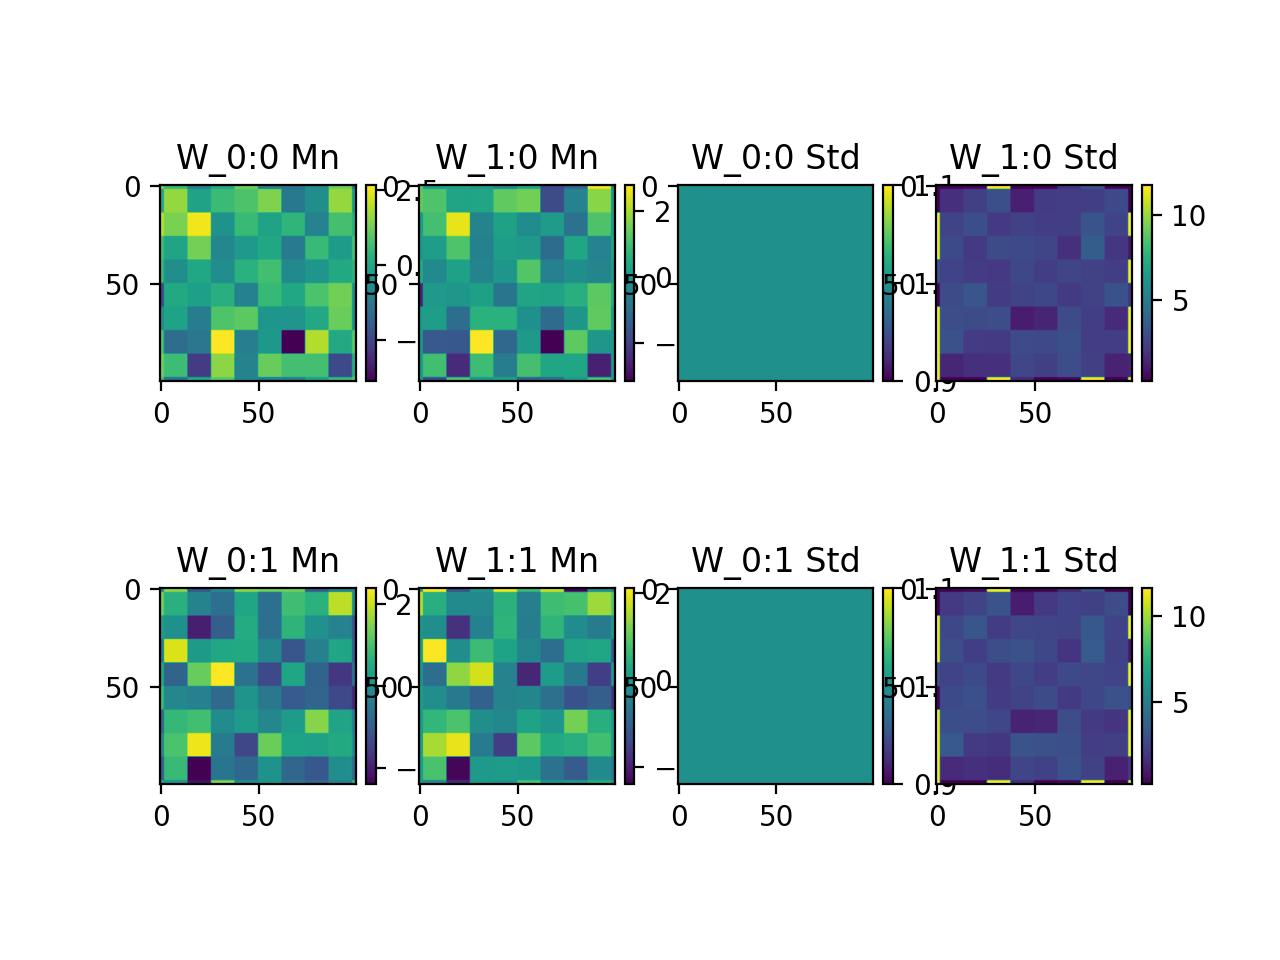

In [25]:
compare_weight_prior_dists(w0_prior=true_priors.w_prior, w1_prior=fit_priors.w_prior, 
                           dim_0_range=[0, 1], dim_1_range=[0, 1], n_pts_per_dim=[100, 100])